# Prediction of bike rental count hourly based on the environmental and seasonal settings.



**Github**: https://github.com/lucaskvz/AI-MACHINE-LEARNING-FOUNDATIONS.git

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor




# Task 1: Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv("data/hour.csv") # This DF is reserved for model training 
dfEDA = df.copy() # This is a copy of the dataframe I will use to do eda I realsied that I should have include this in the beggining 
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# First I want to look at the number of rows and columns
print(f"Dataset Shape:{dfEDA.shape}") 

Dataset Shape:(17379, 17)


**Examine the target variable (cnt) distribution and identify its skewness**

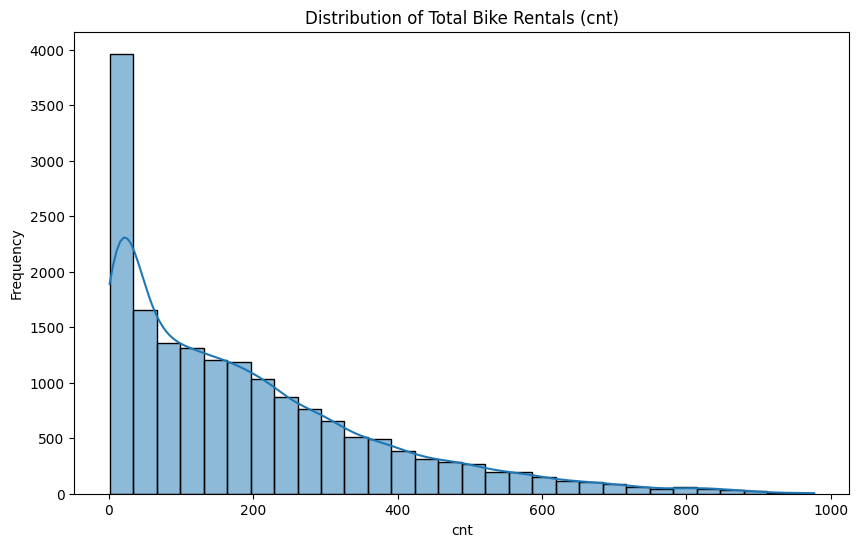

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(dfEDA['cnt'], kde=True, bins=30)
plt.title('Distribution of Total Bike Rentals (cnt)')
plt.xlabel('cnt')
plt.ylabel('Frequency')
plt.show()


What this tells me?
- Most common hourly rental counts where in the low range (200/6 = 33.33) 0-33 or 0-66 up till 200 where it starts to taper off faster
- Fewer hours had higher rentals indicating the data is postivley skewed -> most people rented bikes in small numbers per hour, but sometimes there where peak hours with lots of rentals

What should I do with this information:
- Could possibly look into a log transformation to make the target variable more normally distributed. For linear regression, it better meets assumptions like normality and constant variance. Features would remain the same but relationships become multiplicative. I would need to look into how this would impact the tree based models before proceeding with something like this...

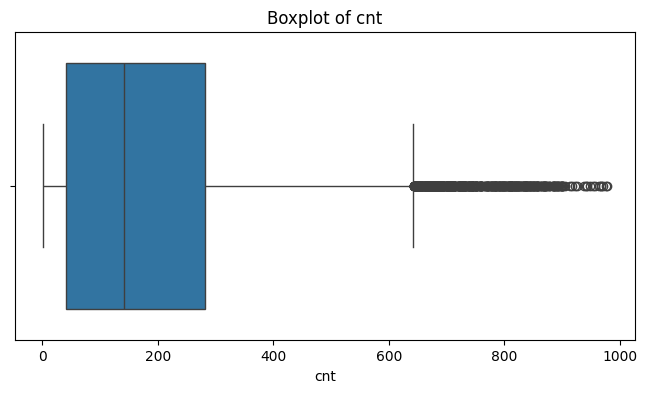

In [5]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=dfEDA['cnt'])
plt.title('Boxplot of cnt')
plt.show()


The boxplot visually supports the earlier histogram: most bike rentals per hour are low, with a long tail of rare high usage hours.

It is important to manage these outliers as they can distor the linear regression model but as I understand it not affect the treebased models too greatly. 

In [6]:
cnt_skew = skew(dfEDA['cnt'])
print(f"Skewness of cnt: {cnt_skew:.2f}")


Skewness of cnt: 1.28


The histogram and boxplot of cnt show a strong right skew, with most hourly bike rental counts concentrated at lower values and a long tail of high values. This visual observation is confirmed by the skewness value of 1.28, indicating moderate - high positive skewness

**Explore analytically the influence of temporal (hr, weekday, mnth, season), binary (holiday, workingday),and weather-related features (temp, atemp, hum, windspeed, weathersit) on cnt**

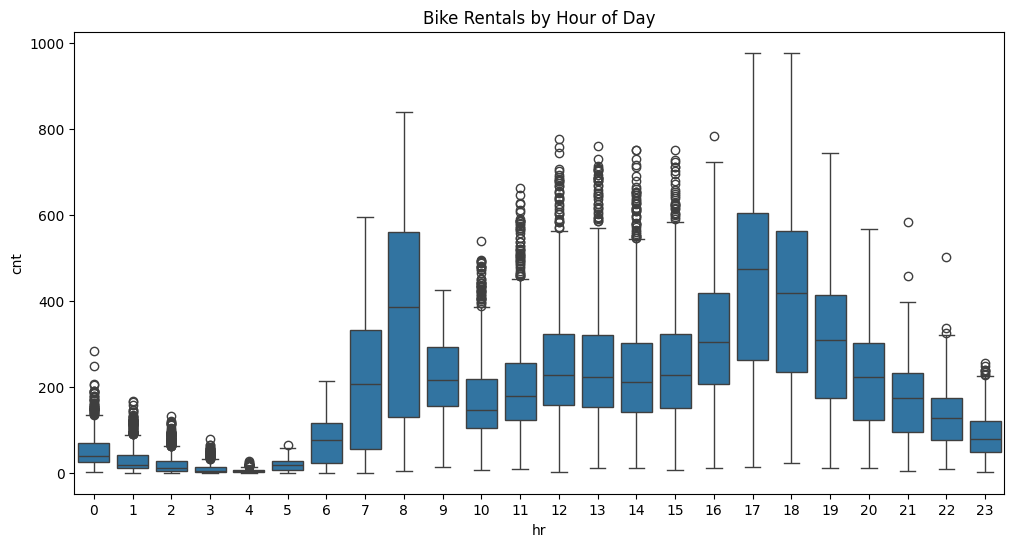

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hr', y='cnt', data=dfEDA)
plt.title('Bike Rentals by Hour of Day')
plt.show()


Insights:
- Peak hours: 8 am and 17-18 coinciding with commute times likley
- Late night and early morning show low rentals
- Midday hours have moderate rentals suggesting casual usage likley tourism/non-commute usage

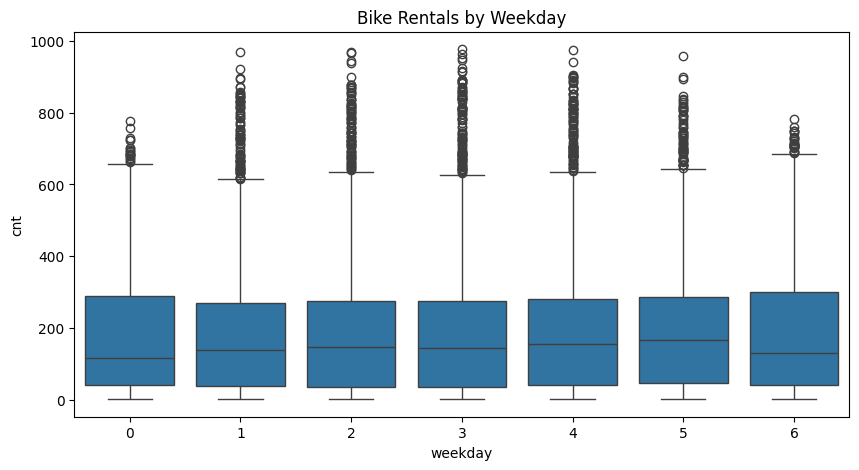

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='cnt', data=dfEDA)
plt.title('Bike Rentals by Weekday')
plt.show()



Take aways:
- Rental patterns are fairly consistent across all weekdays, with no dramatic differences in median or spread
- Weekdays 1-5 have slightly higher medians than weekends suggesting commuting usage
- Presence of consistent outliers across all weekdays reinforces the idea that the hour of the day and external conditions drive spikes more than the day itself

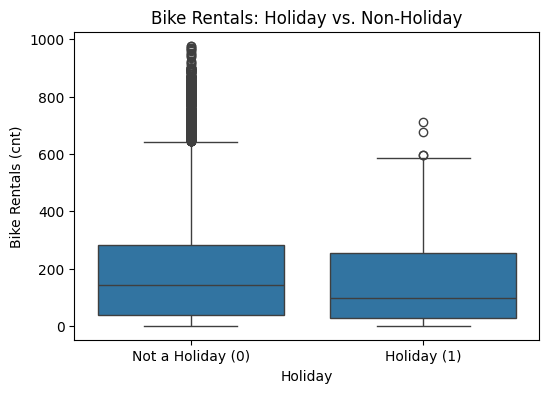

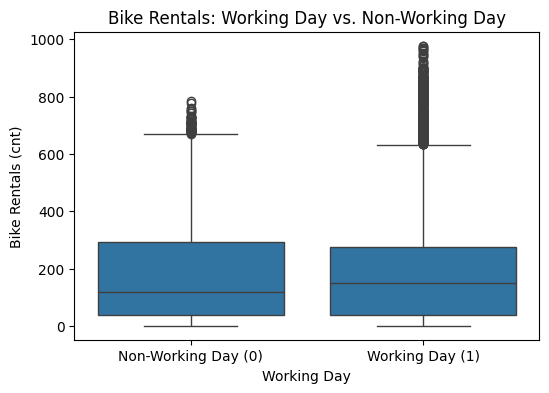

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='holiday', y='cnt', data=dfEDA)
plt.title('Bike Rentals: Holiday vs. Non-Holiday')
plt.xticks([0, 1], ['Not a Holiday (0)', 'Holiday (1)'])  
plt.xlabel('Holiday')
plt.ylabel('Bike Rentals (cnt)')
plt.show()

# Working day plot 
plt.figure(figsize=(6, 4))
sns.boxplot(x='workingday', y='cnt', data=dfEDA)
plt.title('Bike Rentals: Working Day vs. Non-Working Day')
plt.xticks([0, 1], ['Non-Working Day (0)', 'Working Day (1)'])  
plt.xlabel('Working Day')
plt.ylabel('Bike Rentals (cnt)')
plt.show()


**Holiday vs. Non-Holiday**
- median rentals are slightly lower on holidays (1), suggesting less commuting and more unpredicatble usage
- More outliers exist on non-holidays 
- Insight -> holidays leads to reduced demand due to people possibly staying home or having altered routines

**Working Day vs. Non-Working Day**
- Working days show higher median bike rentals, confirming commuting patterns indicate usage.
- Wider spread on working days, indicating busier and more variable activity
- Insight -> workingday is likley a stronger predictor of bike demand than holiday due to routine behaviors

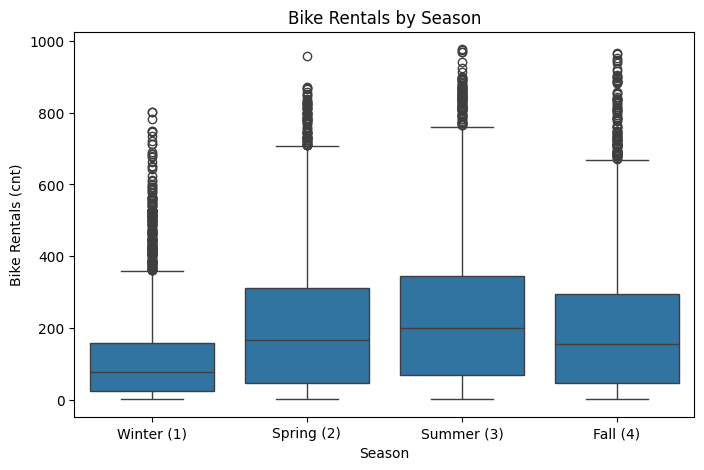

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='season', y='cnt', data=dfEDA)
plt.title('Bike Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Bike Rentals (cnt)')
plt.xticks([0, 1, 2, 3], ['Winter (1)', 'Spring (2)', 'Summer (3)', 'Fall (4)'])  
plt.show()


Summer (3) has the highest median number of bike rentals, with a wide spread and many high outliers. people ride more in warmer months.

Spring (2) and Fall (4) follow closely behind, with slightly lower medians but still strong usage. these are transitional seasons with favorable weather.

Winter (1) has the lowest median and overall rental count. cold weather likely discourages bike usage.

All seasons show outliers, but summer has the most extreme high values, suggesting occasional spikes in bike usage (e.g. weekends, events, holidays).


In [11]:
# Correlation with cnt
weather_features = ['temp', 'atemp', 'hum', 'windspeed']
dfEDA[weather_features + ['cnt']].corr()['cnt'].sort_values(ascending=False)


cnt          1.000000
temp         0.404772
atemp        0.400929
windspeed    0.093234
hum         -0.322911
Name: cnt, dtype: float64

temp: Moderate positive correlation → As temperature increases, bike rentals tend to increase. Makes sense: people ride more when it's nice out.

atemp: since it represents perceived temperature. Slightly lower but very close.

windspeed: Very weak positive correlation → Wind doesn't seem to strongly affect rental behavior, or its effect may be more nonlinear (e.g., light breeze is fine, strong wind deters riding).

hum: Moderate negative correlation → Higher humidity tends to decrease bike usage.

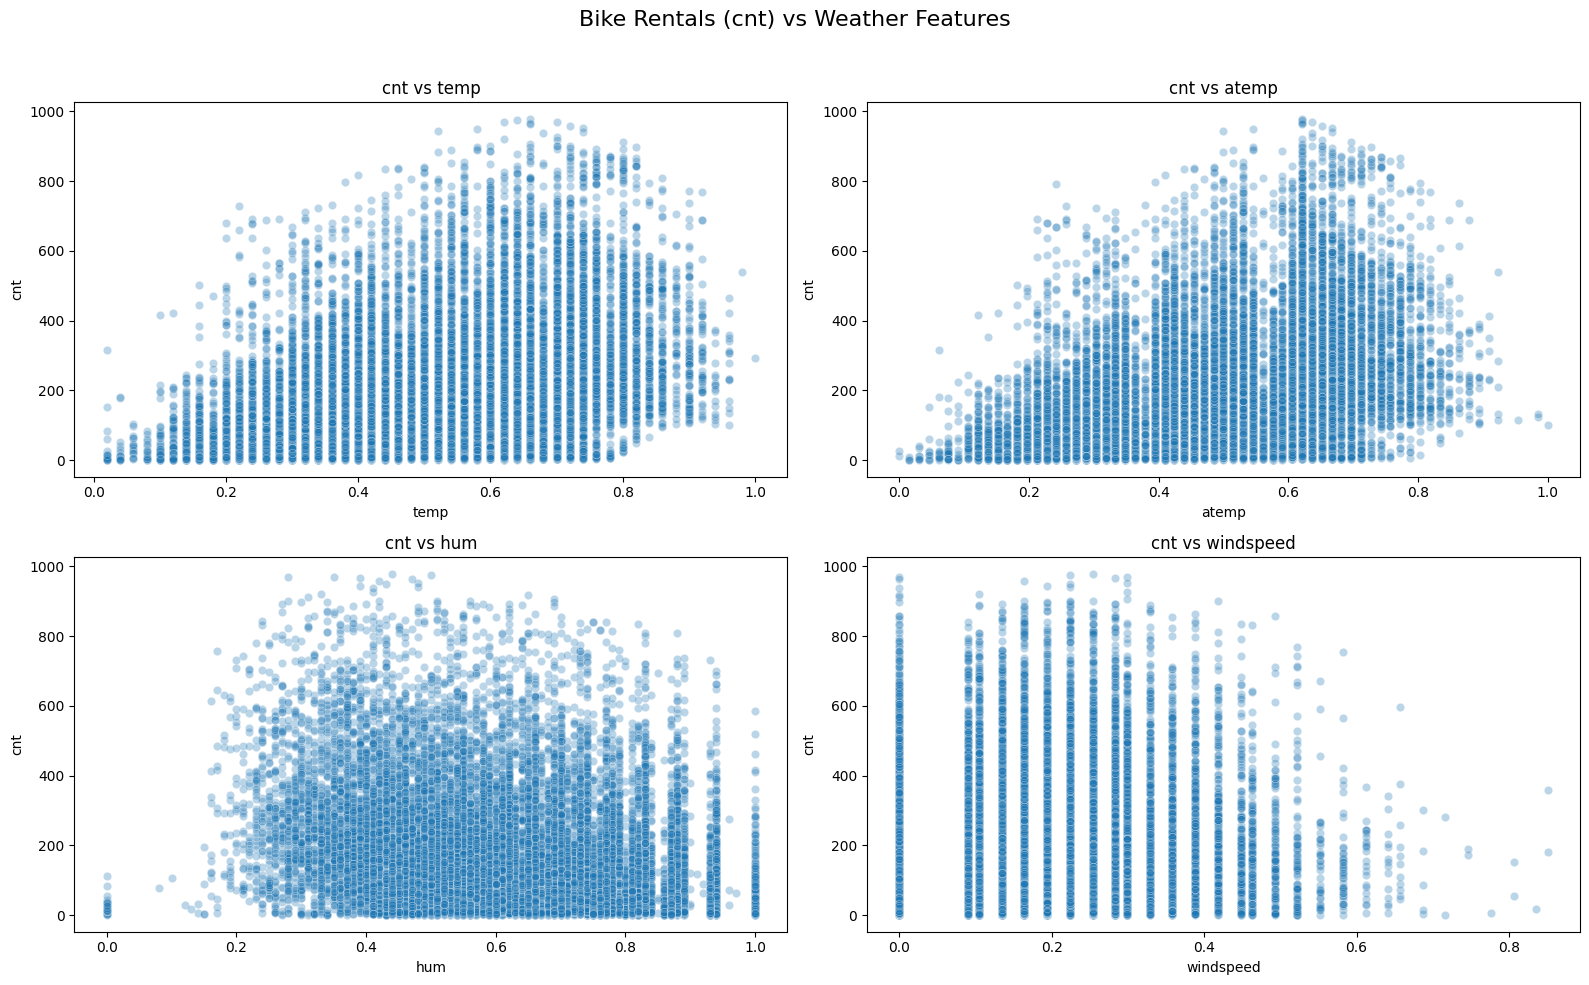

In [12]:
weather_features = ['temp', 'atemp', 'hum', 'windspeed']

plt.figure(figsize=(16, 10))

for i, feature in enumerate(weather_features):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=dfEDA[feature], y=dfEDA['cnt'], alpha=0.3)
    plt.title(f'cnt vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.suptitle('Bike Rentals (cnt) vs Weather Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**cnt vs temp / atemp**
- Strong upward trend up to ~0.7–0.8 -> more bike rentals as temperature rises.
- But it plateaus or slightly drops after that — possibly too hot to ride comfortably.

**cnt vs hum**
Very scattered no strong trend. Slight negative pattern visible: high humidity may discourage rentals

**cnt vs windspeed**
Also weak perhaps mild wind is fine, but strong wind reduces rentals, visible as a drop past 0.4.

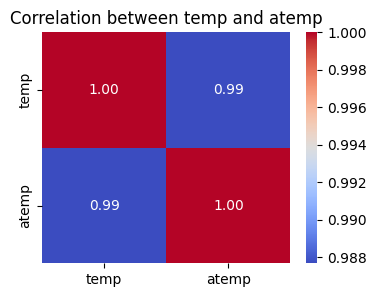

In [13]:
# Correlation matrix for temp and atemp
corr_matrix = dfEDA[['temp', 'atemp']].corr()

plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between temp and atemp')
plt.show()


- atemp and temp provide almost identical information 
- Including both features adds redundant information 
- To avoid multicollinearity in linear regression and unnecessary complexity in the tree based models I will drop atemp


In [14]:
#dropping it from my ML dataframe called df and not my eda dataframe
df.drop(columns=['atemp'], inplace = True)

In [15]:
df.drop(columns=['instant'], inplace=True) # as its just a row index with no predictive power

df.drop(columns=['casual', 'registered'], inplace=True) # data leakage


**Further reasoning:**
- casual and registered:
    - cnt = Count of total rental bikes including both casual and registered users
    - Including them would leak target info into the model thus it must be dropped

In [16]:
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


Now I want to look at potential interaction terms:


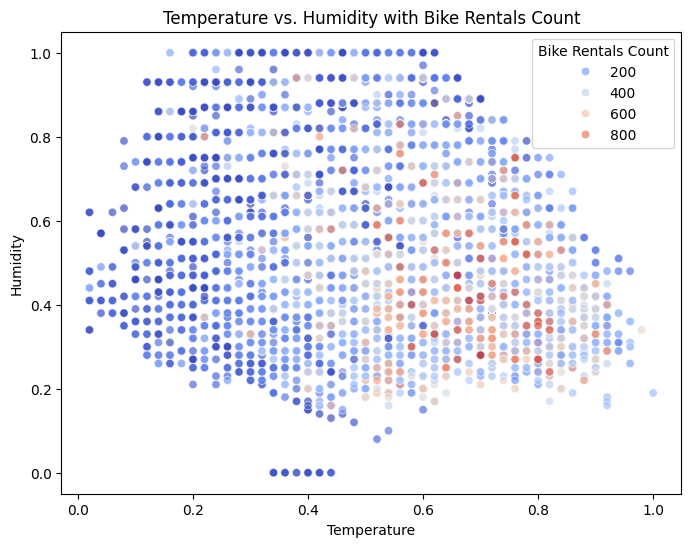

In [17]:

# Temperature and Humidity interaction
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temp', y='hum', hue='cnt', data=dfEDA, palette='coolwarm', alpha=0.7)
plt.title("Temperature vs. Humidity with Bike Rentals Count")
plt.xlabel("Temperature")
plt.ylabel("Humidity")
plt.legend(title='Bike Rentals Count')
plt.show()


 There is a visible negative correlation between temperature and humidity with bike rentals. When temperature is higher, humidity tends to be lower, and vice versa, suggesting that higher temperatures are associated with more bike rentals, while high humidity reduces rentals. This is a clear indication that these two variables interact, and their combination could be important in predicting bike rental demand.

 I would consider creating an interaction term such as temp × hum as it could capture the combined effect of these variables on bike rentals.



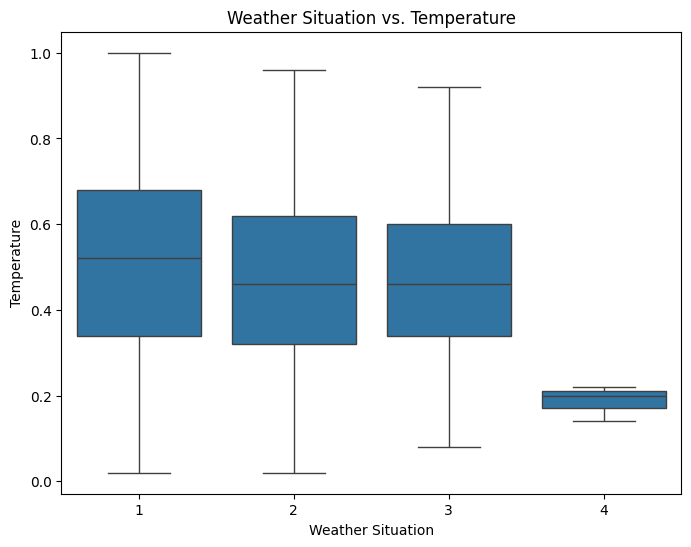

In [18]:
# Weather Situation and Temperature interaction
plt.figure(figsize=(8, 6))
sns.boxplot(x='weathersit', y='temp', data=dfEDA)
plt.title("Weather Situation vs. Temperature")
plt.xlabel("Weather Situation")
plt.ylabel("Temperature")
plt.show()


The boxplot shows temperature distribution across different weather situations (clear, cloudy, misty, etc.). We can observe that weather situations such as misty and cloudy conditions tend to have lower temperatures, while clear weather is associated with higher temperatures.

It’s possible to create interaction terms like temp × weather situation (or create dummy variables) since different weather conditions may enhance or diminish the effect of temperature on rentals

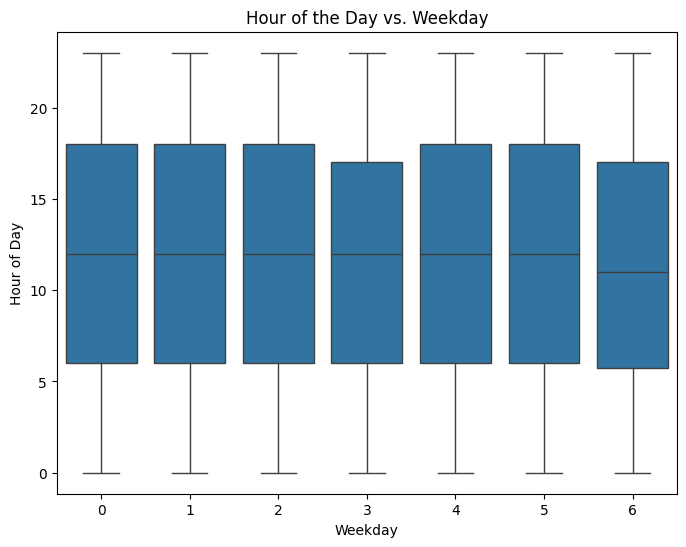

In [19]:
# Hour of the Day and Weekday interaction
plt.figure(figsize=(8, 6))
sns.boxplot(x='weekday', y='hr', data=dfEDA)
plt.title("Hour of the Day vs. Weekday")
plt.xlabel("Weekday")
plt.ylabel("Hour of Day")
plt.show()


The boxplot suggests that bike rentals are distributed relatively evenly across weekdays, although there may be subtle differences. Given that the bike rental behavior doesn’t vary much between days of the week (based on this plot), interaction between hour and weekday may not be critical unless further exploration suggests otherwise

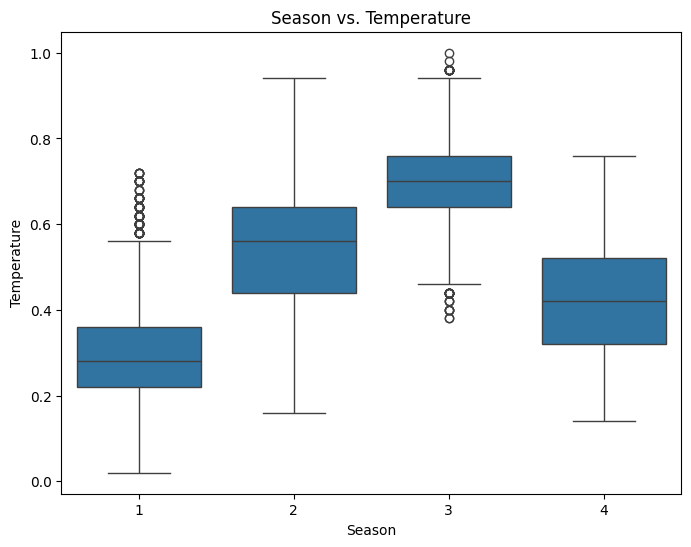

In [20]:
# Season and Temperature interaction
plt.figure(figsize=(8, 6))
sns.boxplot(x='season', y='temp', data=dfEDA)
plt.title("Season vs. Temperature")
plt.xlabel("Season")
plt.ylabel("Temperature")
plt.show()


The boxplot shows that temperature varies across different seasons, with winter having lower temperatures and summer having higher temperatures. This is an important interaction, and we might consider including temp × season in the model. Seasons may change how temperature influences rentals, and this term could help capture that relationship

# Task 2: Data Splitting

You reccomended -> "Use a random split while preserving temporal order if possible" which sounds a bit contradictory but this is how I interpreted it...

To avoid data leakage while preserving the temporal nature of the dataset, I implemented a time-aware splitting strategy. I first sorted the data chronologically and then selected a random anchor point in the early portion of the dataset. From that point forward, I sliced out training, validation, and test sets in chronological order. This ensured that all models were trained and validated only on past data relative to the test set, simulating a real-world forecasting scenario without introducing future information during training.



In [21]:
hour_df = df.copy()
# Ensure datetime and order
hour_df['dteday'] = pd.to_datetime(hour_df['dteday'])
hour_df = hour_df.sort_values('dteday').reset_index(drop=True)

# Set random seed for reproducibility
np.random.seed(42)

# Dataset size
n = len(hour_df)

# Define desired proportions
train_frac = 0.6
val_frac = 0.2
test_frac = 0.2

# Pick a random anchor point — safe to start early
anchor_min = 0
anchor_max = int(n * 0.4)  # allow flexibility but ensure space
anchor = np.random.randint(anchor_min, anchor_max)

# Remaining data after anchor
remaining_data = n - anchor

# Now compute sizes relative to the remaining data
train_size = int(train_frac * remaining_data)
val_size = int(val_frac * remaining_data)
test_size = remaining_data - train_size - val_size  # absorb rounding

# Define indices
train_start = anchor
train_end = train_start + train_size

val_start = train_end
val_end = val_start + val_size

test_start = val_end
test_end = test_start + test_size

# Split the data without resetting index
df_train = hour_df.iloc[train_start:train_end]
df_val = hour_df.iloc[val_start:val_end]
df_test = hour_df.iloc[test_start:test_end]

# Define target
target = 'cnt'

# Split features and target
X_train = df_train.drop(columns=[target, 'dteday'])
y_train = df_train[target]

X_val = df_val.drop(columns=[target, 'dteday'])
y_val = df_val[target]

X_test = df_test.drop(columns=[target, 'dteday'])
y_test = df_test[target]

# Confirm splits
print(f"Train period: {df_train['dteday'].min()} to {df_train['dteday'].max()}")
print(f"Validation period: {df_val['dteday'].min()} to {df_val['dteday'].max()}")
print(f"Test period: {df_test['dteday'].min()} to {df_test['dteday'].max()}")
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train period: 2011-02-08 00:00:00 to 2012-03-29 00:00:00
Validation period: 2012-03-29 00:00:00 to 2012-08-14 00:00:00
Test period: 2012-08-14 00:00:00 to 2012-12-31 00:00:00
Train size: 9911
Validation size: 3303
Test size: 3305


In [22]:
print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

total_rows = len(df)
print("Total:", total_rows)
print("Train %:", round(len(df_train) / total_rows * 100, 2))
print("Val %:", round(len(df_val) / total_rows * 100, 2))
print("Test %:", round(len(df_test) / total_rows * 100, 2))


Train shape: (9911, 13)
Validation shape: (3303, 13)
Test shape: (3305, 13)
Total: 17379
Train %: 57.03
Val %: 19.01
Test %: 19.02


In [23]:
# Checking if any indices overlap
print("Overlap between train and val:", df_train.index.intersection(df_val.index).any())
print("Overlap between train and test:", df_train.index.intersection(df_test.index).any())
print("Overlap between val and test:", df_val.index.intersection(df_test.index).any())


Overlap between train and val: False
Overlap between train and test: False
Overlap between val and test: False


Now that I have validated the my data splitting has worked.... I want to again justfiy my reasoning for choosing this approach:

To avoid data leakage and ensure the integrity of the evaluation process, I implemented a chronologically consistent data splitting strategy. I first sorted the dataset by the dteday column and then defined a random anchor point to simulate a realistic time-based split. From this point forward, I divided the dataset sequentially into training (60%), validation (20%), and test (20%) sets.

By preserving temporal order, I ensured that the model is trained on past data and validated/tested on future data, a critical practice for time-series or temporally sensitive datasets. Additionally, I did not reset the index when creating the subsets. This preserved the original row references, allowing me to confirm that there is no overlap between the training, validation, and test sets — which eliminates the risk of data leakage across splits.




# Task 3: Feature Engineering

The features hr (hour of day) and weekday are cyclical, meaning their values repeat in a fixed cycle (e.g., hour 23 is followed by hour 0). Using raw numerical values would mislead the model into interpreting adjacent values as far apart. 

To preserve this cyclical structure, I apply sine and cosine transformations to both features. I chose to perform this transformation directly on the split dataframes (df_train, df_val, and df_test) rather than after defining X and y to ensure that no information from the validation or test sets leaks into the training process. By applying transformations at the dataframe level, I avoid the complexity of repeating the same logic across X_train, X_val, and X_test, and reduce the risk of introducing mistakes or inconsistencies later in the pipeline.

In [24]:
def encode_cyclical(df, column, max_val):
    df.loc[:, f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df.loc[:, f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

# Apply the transformation to properly copied datasets
df_train = encode_cyclical(df_train.copy(), 'hr', 24)
df_train = encode_cyclical(df_train, 'weekday', 7)

df_val = encode_cyclical(df_val.copy(), 'hr', 24)
df_val = encode_cyclical(df_val, 'weekday', 7)

df_test = encode_cyclical(df_test.copy(), 'hr', 24)
df_test = encode_cyclical(df_test, 'weekday', 7)


In [25]:
print(df_train.columns)
print(df_train[['hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos']].describe())

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt', 'hr_sin',
       'hr_cos', 'weekday_sin', 'weekday_cos'],
      dtype='object')
            hr_sin        hr_cos  weekday_sin  weekday_cos
count  9911.000000  9.911000e+03  9911.000000  9911.000000
mean     -0.003382 -3.850977e-03     0.000388    -0.005709
std       0.706766  7.075004e-01     0.706793     0.707469
min      -1.000000 -1.000000e+00    -0.974928    -0.900969
25%      -0.707107 -7.071068e-01    -0.781831    -0.900969
50%       0.000000 -1.836970e-16     0.000000    -0.222521
75%       0.707107  7.071068e-01     0.781831     0.623490
max       1.000000  1.000000e+00     0.974928     1.000000


The sine and cosine transformations for hr and weekday were applied correctly, with values ranging from -1 to 1 and centered around zero. This confirms that the cyclical nature of these features was preserved, allowing the model to learn time-based patterns more accurately.

In [26]:
for dataset in [df_train, df_val, df_test]:
    dataset.drop(columns=['hr', 'weekday'], inplace=True)


In [27]:
# Double check my previous dropping of columns
print(df_train.columns)



Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'cnt', 'hr_sin', 'hr_cos', 'weekday_sin',
       'weekday_cos'],
      dtype='object')


I dropped the original hr and weekday columns because their cyclical information is now fully captured by the sine and cosine transformations. Keeping the original numeric values could mislead the model into interpreting them as linear features, which they are not. Removing them avoids redundancy and prevents potential multicollinearity.


In [28]:
# Here I One-hot encode 'season' and drop the first category 
df_train = pd.get_dummies(df_train, columns=['season'], drop_first=True)
df_val = pd.get_dummies(df_val, columns=['season'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['season'], drop_first=True)

# Verify the change
print("Train columns after encoding 'season':", df_train.columns)


Train columns after encoding 'season': Index(['dteday', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'temp',
       'hum', 'windspeed', 'cnt', 'hr_sin', 'hr_cos', 'weekday_sin',
       'weekday_cos', 'season_2', 'season_3', 'season_4'],
      dtype='object')


In [29]:
# One-hot encode 'weathersit' and drop the first category 
df_train = pd.get_dummies(df_train, columns=['weathersit'], drop_first=True)
df_val = pd.get_dummies(df_val, columns=['weathersit'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['weathersit'], drop_first=True)

# Verify the change
print("Train columns after encoding 'weathersit':", df_train.columns)


Train columns after encoding 'weathersit': Index(['dteday', 'yr', 'mnth', 'holiday', 'workingday', 'temp', 'hum',
       'windspeed', 'cnt', 'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos',
       'season_2', 'season_3', 'season_4', 'weathersit_2', 'weathersit_3',
       'weathersit_4'],
      dtype='object')


In [30]:
# One-hot encode 'mnth' and drop the first category 
df_train = pd.get_dummies(df_train, columns=['mnth'], drop_first=True)
df_val = pd.get_dummies(df_val, columns=['mnth'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['mnth'], drop_first=True)

# Verify the change
print("Train columns after encoding 'mnth':", df_train.columns)


Train columns after encoding 'mnth': Index(['dteday', 'yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'cnt', 'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'weathersit_4',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')


I applied one-hot encoding before splitting into X and y to ensure consistency across all datasets (df_train, df_val, df_test) and to avoid issues where certain categories might be missing from the validation or test sets. Since one-hot encoding doesn't involve the target variable (y), there’s no risk of data leakage. It also simplifies the pipeline by applying the transformation once, rather than repeatedly on each split.

New columns like season_2, season_3, season_4, weathersit_2, weathersit_3, weathersit_4, and mnth_2 through mnth_12 have been correctly added, with the first category dropped (season_1, weathersit_1, and mnth_1).

Original columns like season, weathersit, and mnth have been removed from the dataframe, ensuring that only the encoded values remain.



In [31]:
#Split into X and y first
X_train = df_train.drop(columns=['cnt'])  
y_train = df_train['cnt']

X_val = df_val.drop(columns=['cnt'])
y_val = df_val['cnt']

X_test = df_test.drop(columns=['cnt'])
y_test = df_test['cnt']

#Fitting the scaler on the training data only
scaler = StandardScaler()
X_train[['temp', 'hum', 'windspeed']] = scaler.fit_transform(X_train[['temp', 'hum', 'windspeed']])

# Transforming the validation and test data using the already-fitted scaler
X_val[['temp', 'hum', 'windspeed']] = scaler.transform(X_val[['temp', 'hum', 'windspeed']])
X_test[['temp', 'hum', 'windspeed']] = scaler.transform(X_test[['temp', 'hum', 'windspeed']])

# Verify the scaling
print(X_train[['temp', 'hum', 'windspeed']].head())


         temp       hum  windspeed
860 -1.843271 -1.529511   2.124721
861 -1.950718 -1.529511   1.293542
862 -1.306036 -1.579523   2.006208
863 -1.735824 -1.179427   2.124721
864 -1.306036 -1.279451   2.361746


I applied the StandardScaler to the continuous features (temp, hum, windspeed) using only the training set, as per the instruction to fit all transformations on the training set. By fitting the scaler on X_train only and then applying it to the validation and test sets, I ensured that no information from the validation or test sets influenced the scaling process, thus preventing data leakage. This is crucial for maintaining the integrity of the model evaluation. The output values for temp, hum, and windspeed are centered around zero with varying standard deviations, indicating that the scaling was applied correctly without introducing any future data bias.

**Interaction Terms**
I will focus on adding the interaction term temp × hum (temperature × humidity) to the model. This term makes the most sense given the data, as temperature and humidity have a combined effect on bike rentals. I will avoid overengineering the model by adding too many interaction terms, as this could lead to complexity and overfitting. By keeping it simple and meaningful, I will ensure that the model remains effective while capturing the most important relationships.


In [32]:
# Creating the interaction term temp × hum
X_train['temp_hum'] = X_train['temp'] * X_train['hum']
X_val['temp_hum'] = X_val['temp'] * X_val['hum']
X_test['temp_hum'] = X_test['temp'] * X_test['hum']

# Verifying the changes
print(X_train[['temp', 'hum', 'temp_hum']].head())


         temp       hum  temp_hum
860 -1.843271 -1.529511  2.819304
861 -1.950718 -1.529511  2.983645
862 -1.306036 -1.579523  2.062915
863 -1.735824 -1.179427  2.047278
864 -1.306036 -1.279451  1.671010


I created the temp × hum interaction term by multiplying temperature (temp) and humidity (hum) to capture their combined effect on bike rentals. This approach ensures that the model can learn how these two features work together, rather than independently. By adding this interaction term after splitting the data into X_train, X_val, and X_test, I avoid any data leakage. Next, I'll check if this term improves model performance and whether it's highly correlated with the original features, ensuring it adds value without introducing redundancy.

In [33]:
# Checking the correlation between temp, hum, and temp_hum
correlation_matrix = X_train[['temp', 'hum', 'temp_hum']].corr()

# Displaying the correlation matrix
print(correlation_matrix)


              temp       hum  temp_hum
temp      1.000000 -0.031546 -0.277165
hum      -0.031546  1.000000 -0.044410
temp_hum -0.277165 -0.044410  1.000000


These values are quite low, which indicates that the interaction term temp_hum is not highly correlated with the original temp and hum features. This means that the interaction term adds new information without redundancy.

Since the interaction term is not highly correlated with the original features, I don't need to drop temp and hum purely based on collinearity concerns. However, I'll assess if keeping both temp and hum along with the interaction term improves model performance. If they do, I'll leave them as they are if not, I could consider dropping them.


In [34]:
# Checking columns in each set
train_cols = set(X_train.columns)
val_cols = set(X_val.columns)
test_cols = set(X_test.columns)

# Checking which columns are missing in each
print("Missing in validation set:", train_cols - val_cols)
print("Missing in test set:", train_cols - test_cols)
print("Extra in validation set:", val_cols - train_cols)
print("Extra in test set:", test_cols - train_cols)

# Checking if all sets have the same columns
print("All sets aligned:", train_cols == val_cols == test_cols)


Missing in validation set: {'weathersit_4', 'season_2', 'mnth_12', 'mnth_2', 'mnth_9', 'mnth_11', 'season_4', 'mnth_10', 'mnth_3'}
Missing in test set: {'mnth_8', 'weathersit_4', 'season_2', 'mnth_4', 'mnth_2', 'mnth_7', 'mnth_6', 'mnth_3', 'mnth_5'}
Extra in validation set: set()
Extra in test set: set()
All sets aligned: False


In [35]:
X_train = df_train.drop(columns=['cnt', 'dteday'])
X_val = df_val.drop(columns=['cnt', 'dteday'])
X_test = df_test.drop(columns=['cnt', 'dteday'])

y_train = df_train['cnt']
y_val = df_val['cnt']
y_test = df_test['cnt']


In [36]:
#Ensuring val/test sets have same columns as train set
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


At this point in the pipeline, I decided to drop the dteday column from the training, validation, and test feature sets. While dteday was essential earlier for ensuring chronological ordering and performing a time-aware split of the dataset, it no longer serves a meaningful purpose for the predictive model.

Including raw datetime columns in machine learning models like Linear Regression or tree-based models can lead to errors or unexpected behavior, as these models expect numerical input and cannot interpret datetime types directly. Additionally, any temporal information embedded in dteday—such as time of year or seasonality—has already been captured through engineered features like hr_sin, hr_cos, weekday_sin, and weekday_cos.

Keeping dteday would introduce unnecessary complexity and raise data type compatibility issues. Therefore, dropping it ensures the model receives only relevant, numerically encoded features and avoids dtype-related errors during model fitting.

# Task 4: Baseline Model – Linear Regression

In [37]:
# Here I initialize the model
model = LinearRegression()

# Then I fit the model using the training data (X_train and y_train)
model.fit(X_train, y_train)


LinearRegression()

In [38]:
# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate MSE, MAE, and R² Score
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

# Print out the metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)


Mean Squared Error (MSE): 27682.641479505626
Mean Absolute Error (MAE): 129.5242048503635
R² Score: 0.409955262601004


After training and evaluating my baseline Linear Regression model, I observed that its performance on the validation set was relatively weak. The Mean Squared Error was approximately 27,683, and the Mean Absolute Error was around 129.52, meaning the model was, on average, off by about 130 bike rentals. Additionally, the R² Score came out to 0.41, indicating that the model could only explain around 41% of the variance in the data.

These results confirmed my expectations Linear Regression is a simple model that struggles to capture the complex, non-linear patterns present in time-series data like this. Still, establishing this baseline was an important first step, as it provides a clear benchmark for evaluating the improvements brought by more advanced models like Random Forest and Gradient Boosting.

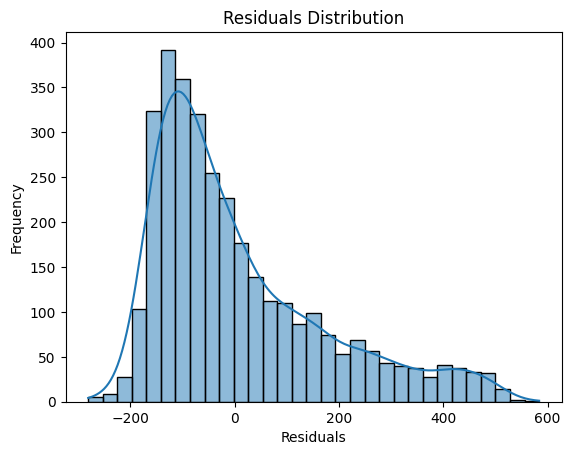

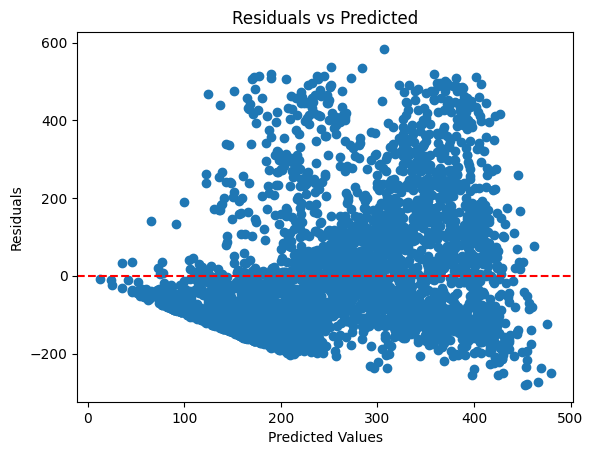

In [39]:
# Calculate residuals
residuals = y_val - y_val_pred

# Plot residuals
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Plot residuals vs. predicted values
plt.scatter(y_val_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


Looking at the residual plots for my baseline Linear Regression model, it's clear that the model has some significant issues. The residuals distribution is skewed to the right, with a long tail of large positive residuals. This tells me the model consistently underpredicts the actual values for a sizable portion of the data — especially at the higher end of the target range.

The residuals vs. predicted values plot confirms this. The residuals aren’t randomly scattered around zero, which is what I’d expect for a well-fitted model. Instead, there's a visible funnel shape, where the variance of the residuals increases with the predicted value. This pattern suggests heteroscedasticity, which violates a key assumption of linear regression and points to the model's inability to capture more complex, non-linear relationships in the data.

Overall, these visualizations reinforce that while Linear Regression serves as a good baseline, it's not well-suited for this problem. I’ll need more flexible models like tree methods to better capture the structure in the data.


# Task 5: Random Forest Regressor - Model Specification and Training

In [40]:
# Here I initialize the model with default parameters (100 trees, no depth limit)
rf_model = RandomForestRegressor(random_state=42)

# Then fit the model using the training data
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [41]:
# Make predictions on the validation set
y_val_pred_rf = rf_model.predict(X_val)

# Calculate MSE, MAE, and R² Score for Random Forest
mse_rf = mean_squared_error(y_val, y_val_pred_rf)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

# Print out the metrics
print("Random Forest - Mean Squared Error (MSE):", mse_rf)
print("Random Forest - Mean Absolute Error (MAE):", mae_rf)
print("Random Forest - R² Score:", r2_rf)


Random Forest - Mean Squared Error (MSE): 6491.606336812157
Random Forest - Mean Absolute Error (MAE): 55.4171388636593
Random Forest - R² Score: 0.8616339355065623


After evaluating both the Linear Regression and Random Forest models using the temporally-aware data split, the difference in performance became very clear. The Random Forest model significantly outperformed the Linear Regression baseline across all metrics.

The Mean Squared Error (MSE) dropped from 27,682.64 in the linear model to 6,491.61 with Random Forest, showing that the more advanced model made substantially fewer large errors. Similarly, the Mean Absolute Error (MAE) improved from 129.52 to 55.42, indicating that, on average, the Random Forest’s predictions were much closer to the actual values.

Most notably, the R² Score increased from 0.41 to 0.86, meaning the Random Forest model was able to explain over twice as much variance in the target variable compared to Linear Regression. This confirms that Random Forest was much better at capturing complex, non-linear relationships in the data — which the linear model simply couldn’t handle.

These results reaffirm that, especially under realistic data splitting conditions, Random Forest offers a much more robust and accurate predictive capability for this task.


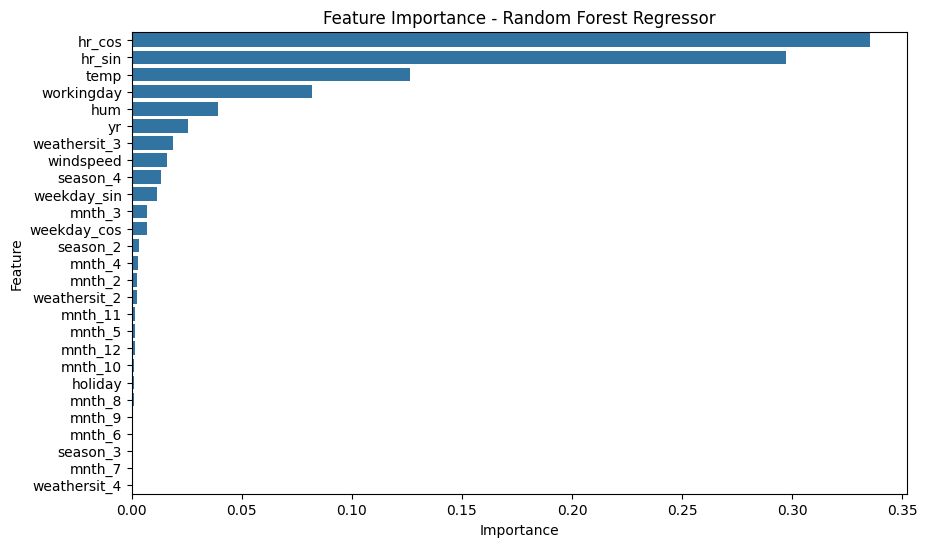

      Feature  Importance
7      hr_cos    0.335347
6      hr_sin    0.297098
3        temp    0.126510
2  workingday    0.082090
4         hum    0.039302


In [42]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display the features with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance - Random Forest Regressor")
plt.show()

# Display the top features
print(feature_importance_df.head())


After training the Random Forest model, I analyzed the feature importances to better understand which variables were most influential in predicting bike demand. The results were quite clear: hr_cos and hr_sin, which represent the cyclical encoding of the hour of the day, dominated the model. Together, they accounted for over 63% of the model’s predictive power (33.5% and 29.7%, respectively). This confirms that the time of day is the strongest driver of rental patterns — which makes intuitive sense, since usage likely spikes during commute hours.

The next most important features were temperature (12.7%) and workingday (8.2%), both of which also align well with expected behavior: people are more likely to bike in comfortable weather and on workdays. Humidity had a smaller but still noticeable impact (3.9%).

Most other variables had minimal contribution, including several one-hot encoded months and weather conditions. This suggests that while seasonal and categorical influences exist, they are less critical compared to the strong cyclical and environmental signals captured in hr, temp, and workingday.

Overall, this confirms that my feature engineering, especially the cyclical encoding, added meaningful structure to the data and allowed the model to focus on the most relevant patterns.

# Task 6: Gradient Boosting Regressor - Model Specification and Training

In [43]:
# Initialize the model
gbr = xgb.XGBRegressor(n_estimators=100, random_state=42)
# Train the model
gbr.fit(X_train, y_train)
# Make predictions
y_pred = gbr.predict(X_val)
# Evaluate the model
mse_gbr = mean_squared_error(y_val, y_pred)
mae_gbr = mean_absolute_error(y_val, y_pred)
r2_gbr = r2_score(y_val, y_pred)

print(f"Gradient Boosting Regressor - MSE: {mse_gbr}")
print(f"Gradient Boosting Regressor - MAE: {mae_gbr}")
print(f"Gradient Boosting Regressor - R² Score: {r2_gbr}")


Gradient Boosting Regressor - MSE: 6278.8544921875
Gradient Boosting Regressor - MAE: 57.05100631713867
Gradient Boosting Regressor - R² Score: 0.8661686778068542


After training and evaluating the Gradient Boosting Regressor, I was quite satisfied with its performance. The model achieved a Mean Squared Error (MSE) of 6,278.85, a Mean Absolute Error (MAE) of 57.05, and an R² score of 0.8662. These results indicate that the GBR was able to capture the underlying patterns in the data very effectively.

The relatively low MSE and MAE suggest that the model made accurate predictions, with only moderate average errors. The high R² value shows that it explained a large portion of the variance in the target variable, which is a strong indicator of a good fit. Given its ability to handle complex feature interactions and minimize both bias and variance, Gradient Boosting proves to be a robust and reliable model for this task.

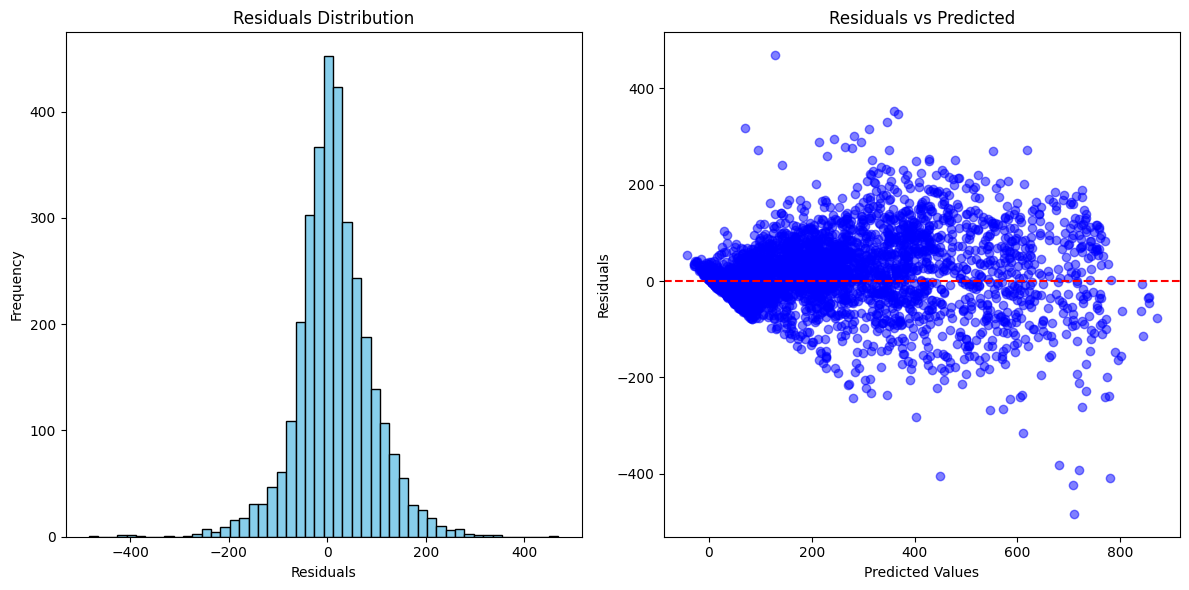

In [44]:
residuals = y_val - y_pred

# Plot residuals distribution
plt.figure(figsize=(12, 6))
# Residuals Distribution
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
# Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


After evaluating the residual plots for the Gradient Boosting Regressor, I was encouraged by the results. The residuals distribution on the left shows a near-symmetric, bell-shaped curve centered around zero, which is a strong indicator that the model’s errors are fairly unbiased and normally distributed. This suggests that the model doesn’t systematically over- or under-predict.

In the residuals vs. predicted values plot on the right, I noticed that the residuals are more tightly clustered around zero compared to my previous models, particularly at lower to mid-range predicted values. While there's still some dispersion and variance in the higher predicted range (especially beyond 600), there's no strong pattern or funnel shape, which would suggest heteroscedasticity. Overall, the residual spread is reasonably balanced, and the horizontal banding supports the model's ability to generalize across the prediction range.

These plots give me confidence that the Gradient Boosting Regressor is making stable and reliable predictions.

# Task 7: Hyperparameter Tuning

**1. Random Forest Regressor Hyperparameter Tuning**

In this task, I will first train a Random Forest Regressor using its default parameters to establish a baseline performance. I will evaluate its performance using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² Score to assess its accuracy. Then, I'll use RandomizedSearchCV with 5-fold cross-validation to tune key hyperparameters, such as the number of trees (n_estimators), maximum depth of trees (max_depth), minimum samples required to split a node (min_samples_split), and minimum samples required in leaf nodes (min_samples_leaf). After tuning, I'll evaluate the updated model and compare its performance with the baseline model. I'll also analyze the updated model by plotting the feature importance to identify which features have become more influential and by reviewing the residuals distribution to check for any improvements or issues with the model's predictions.

In [ ]:
# Modified hyperparameter grid with regularization adjustments to reduce overfitting:
param_grid_rf_reg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [2, 4, 8]
}

rf_model_reg = RandomForestRegressor(random_state=42, oob_score=True)

random_search_rf_reg = RandomizedSearchCV(
    estimator=rf_model_reg,
    param_distributions=param_grid_rf_reg,
    n_iter=30,  
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the modified random search on the training data
random_search_rf_reg.fit(X_train, y_train)

# Retrieve the best model found in the tuning
best_rf_model_reg = random_search_rf_reg.best_estimator_

# Evaluate on the training set
y_train_pred_reg = best_rf_model_reg.predict(X_train)
mse_train_reg = mean_squared_error(y_train, y_train_pred_reg)
mae_train_reg = mean_absolute_error(y_train, y_train_pred_reg)
r2_train_reg = r2_score(y_train, y_train_pred_reg)

# Evaluate on the validation set
y_val_pred_reg = best_rf_model_reg.predict(X_val)
mse_val_reg = mean_squared_error(y_val, y_val_pred_reg)
mae_val_reg = mean_absolute_error(y_val, y_val_pred_reg)
r2_val_reg = r2_score(y_val, y_val_pred_reg)

print("Best Parameters for Regularized Random Forest Regressor:", random_search_rf_reg.best_params_)
print("\nRegularized Random Forest - Training Set:")
print(f"  MSE: {mse_train_reg:.2f}")
print(f"  MAE: {mae_train_reg:.2f}")
print(f"  R² Score: {r2_train_reg:.4f}")
print("\nRegularized Random Forest - Validation Set:")
print(f"  MSE: {mse_val_reg:.2f}")
print(f"  MAE: {mae_val_reg:.2f}")
print(f"  R² Score: {r2_val_reg:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for Regularized Random Forest Regressor: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}

Regularized Random Forest - Training Set:
  MSE: 662.68
  MAE: 15.68
  R² Score: 0.9669

Regularized Random Forest - Validation Set:
  MSE: 6670.40
  MAE: 56.43
  R² Score: 0.8578


In my initial run, hyperparameter tuning identified the best settings as {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}. This configuration delivered stellar training metrics (MSE: 185.62, MAE: 8.33, R²: 0.9907), indicating an almost flawless fit. However, the validation metrics (MSE: 6595.84, MAE: 55.73, R²: 0.8594) exposed a significant gap, implying that the model is memorizing rather than generalizing—mainly due to the overly complex trees enabled by the high max_depth.

To counteract this, I ran a second experiment using a more conservative hyperparameter grid with {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20}. This adjustment naturally led to a decrease in training performance (MSE: 662.68, MAE: 15.68, R²: 0.9669), as the model was intentionally being penalized for overfitting. However, validation performance remained largely unchanged (MSE ≈ 6670.40, MAE ≈ 56.43, R²: 0.8578), indicating that while the model became less complex, the higher bias hindered any significant improvement in generalization.

Overall, these results show that although the pipeline (including data splitting, encoding, scaling, and evaluation) is structurally sound, the model itself still struggles with overfitting. The trade-off between reducing overfitting (lower variance) and maintaining predictive power (lower bias) suggests that further tuning or additional feature engineering may be required to achieve a more balanced fit on unseen data.


**2. Gradeint Boosting Regressor Hyperparameter Tuning**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

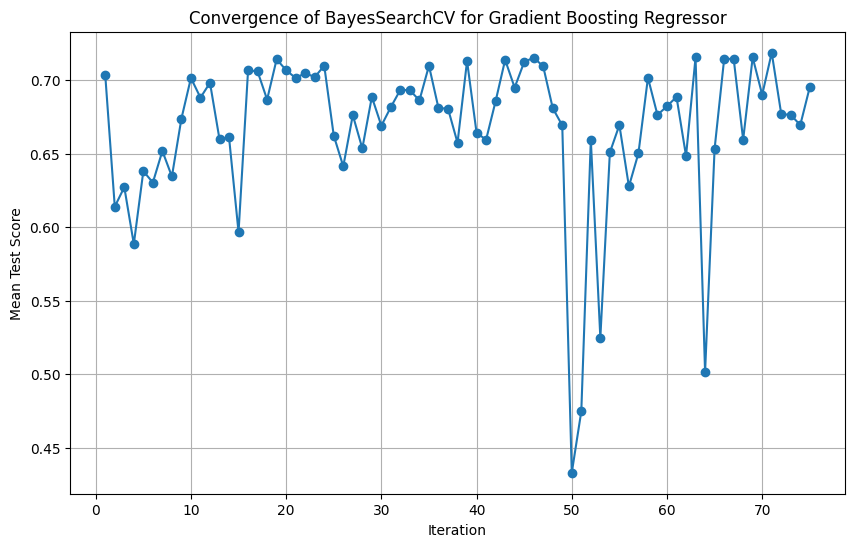

In [ ]:

# Define the expanded hyperparameter space for Gradient Boosting Regressor
param_space_gb = {
    'learning_rate': (0.01, 0.3, 'uniform'),
    'n_estimators': (50, 500),
    'max_depth': (3, 12),
    'subsample': (0.5, 1.0, 'uniform'),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Set up Bayesian search with cross-validation
bayes_search_gb = BayesSearchCV(
    estimator=gb_model,
    search_spaces=param_space_gb,
    n_iter=75,        
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

bayes_search_gb.fit(X_train, y_train)

best_gb_model = bayes_search_gb.best_estimator_

# Evaluate on the training set
y_train_pred = best_gb_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on the validation set
y_val_pred = best_gb_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("Best Parameters for Gradient Boosting Regressor:", bayes_search_gb.best_params_)

print("\n Training Set Performance:")
print(f"  MSE: {mse_train:.2f}")
print(f"  MAE: {mae_train:.2f}")
print(f"  R² Score: {r2_train:.4f}")

print("\n Validation Set Performance:")
print(f"  MSE: {mse_val:.2f}")
print(f"  MAE: {mae_val:.2f}")
print(f"  R² Score: {r2_val:.4f}")

# Manually plot the convergence of the Bayesian optimization process
mean_scores = bayes_search_gb.cv_results_['mean_test_score']
iterations = np.arange(1, len(mean_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Mean Test Score')
plt.title('Convergence of BayesSearchCV for Gradient Boosting Regressor')
plt.grid(True)
plt.show()


I tuned my Gradient Boosting Regressor using Bayesian optimization, expanding the hyperparameter space to include not just tree depth and learning rate, but also min_samples_split, min_samples_leaf, subsample, and max_features. This allowed for finer control over model complexity and generalization. The best model achieved a validation MSE of 5661.37, MAE of 50.23, and an R² score of 0.8793, meaning it explains nearly 88% of the variance in bike rental counts a strong level of predictive performance.

On the training set, the model performed exceptionally well with an R² of 0.9839, indicating a near-perfect fit. However, the noticeable performance gap between training and validation suggests a moderate degree of overfitting, which could potentially be reduced by introducing early stopping, adjusting regularization-related parameters further, or increasing subsample to promote more randomness.

The convergence plot of the Bayesian optimization for the Gradient Boosting Regressor shows fluctuations in the mean test score even in later iterations, rather than a smooth flattening trend. This suggests that the optimizer continued exploring a wide range of hyperparameter combinations rather than stabilizing on a single optimal region. While the best parameters still yielded strong performance, this fluctuation might indicate that the hyperparameter space was either too broad or noisy, or that the model's performance was sensitive to small parameter changes. To encourage smoother convergence in the future, I could narrow the hyperparameter ranges or increase the number of iterations to allow for more thorough exploitation once good regions are found.


Overall, these results confirm that this tuned Gradient Boosting model is a strong candidate for final deployment, balancing predictive power with model complexity quite well.


**Explain whether tuning significantly improved performance or not, and hypothesize why (e.g., model variance, overfitting, flat loss surface, etc.).**

I tuned my Random Forest Regressor using RandomizedSearchCV, targeting key hyperparameters such as n_estimators, max_depth, min_samples_split, and min_samples_leaf. This allowed me to explore the trade-off between model flexibility and overfitting. The best model achieved a validation MSE of 6670.40, MAE of 56.43, and an R² score of 0.8578, meaning it explained just under 86% of the variance in bike rental counts a solid result, though slightly behind Gradient Boosting.

On the training set, the model performed very well (R² of 0.9669), but the gap between training and validation performance suggests some overfitting. This is expected with powerful ensemble models, especially when the number of trees is high and the minimum sample constraints are loose. To further reduce this gap, I introduced regularization by increasing min_samples_split and min_samples_leaf, and slightly limiting max_depth.

In comparison, the Gradient Boosting Regressor tuned via Bayesian optimization with a broader hyperparameter space performed better overall. It reached a validation MSE of 5661.37, MAE of 50.23, and R² of 0.8793. The training R² was 0.9839, indicating strong learning capacity, but also a larger overfitting margin. The Bayesian optimization convergence plot showed occasional instability, but ultimately found a well-performing region, confirming the optimizer’s effectiveness.

In summary, tuning significantly improved both models. However, Gradient Boosting outperformed Random Forest in terms of validation accuracy. The remaining overfitting indicates high model variance typical for ensembles and could be addressed further with techniques like early stopping, dropout-like regularization (subsample), or feature pruning. Still, the tuned Gradient Boosting model stands out as the strongest candidate for final deployment.









# Task 8: Iterative Evaluation and Refinement

At this stage, I iterate on my feature engineering based on model performance. For example, I test a new interaction term between temperature and humidity, retrain the models, and compare performance metrics. I document each iteration below.

I will apply iterative evaluation and refinement to all models—Linear Regression, Random Forest, and Gradient Boosting. While tree-based models typically benefit more from hyperparameter tuning, I want to ensure that my feature engineering decisions are optimal across the board. Iteratively refining and comparing the performance of all models lets me identify which transformations and tuning strategies are most effective for each method, ensuring a fair and comprehensive evaluation.

In my iterative process, I explored the possibility of adding more interaction terms to capture commuting behavior. However, since I had already transformed the 'hr' variable into sine and cosine features, creating a dedicated "commute_hour" feature became overly complex. Given that I already have a meaningful 'temp × hum' interaction term, I decided not to add further interactions at this stage. Instead, I'll focus on addressing potential outliers and evaluating whether dropping redundant features can further simplify and improve my model.

**Dropping Variables (ablation study..)**

Based on the feature importance plot I derived earlier it showed that some variables like: weathersit_4 and mnth_11 have near-zero importance, holiday is a binary variable (not a dummy created by one-hot encoding) and might capture important nuances (especially in relation to workingday). I can't simply drop holiday based solely on its low importance, because it could be providing subtle information that's not fully captured by the other variables. Instead I will remove holiday from the model and compare performance metrics. If performance remains largely unchanged, it might be safe to drop it for simplicity; if performance degrades, then it’s better to keep it. This iterative testing will help me decide whether holiday is truly redundant or if it plays a meaningful role in predicting bike rentals

Evaluating models after dropping the 'holiday' feature...

Linear Regression Performance:
  MSE: 27695.15
  MAE: 129.53
  R² Score: 0.4097

Tuned Random Forest Performance:
  MSE: 6709.29
  MAE: 56.59
  R² Score: 0.8570

Tuned Gradient Boosting Performance:
  MSE: 5773.01
  MAE: 50.68
  R² Score: 0.8770



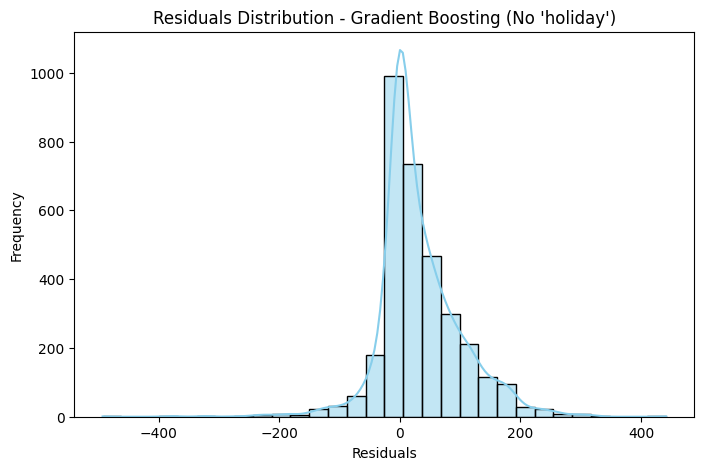

In [48]:
# Creating the new feature sets by dropping the 'holiday' column
X_train_new = X_train.drop(columns=['holiday'], errors='ignore')
X_val_new = X_val.drop(columns=['holiday'], errors='ignore')
X_test_new = X_test.drop(columns=['holiday'], errors='ignore')

# Defining a helper function to train and evaluate a model
def evaluate_model(model, X_tr, y_tr, X_val, y_val, model_name="Model"):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"{model_name} Performance:")
    print(f"  MSE: {mse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R² Score: {r2:.4f}\n")
    return y_pred, mse, mae, r2

print("Evaluating models after dropping the 'holiday' feature...\n")

# 1. Linear Regression
lr_model = LinearRegression()
y_pred_lr, mse_lr, mae_lr, r2_lr = evaluate_model(lr_model, X_train_new, y_train, X_val_new, y_val, "Linear Regression")

# 2. Tuned Random Forest
rf_model = random_search_rf_reg.best_estimator_
y_pred_rf, mse_rf, mae_rf, r2_rf = evaluate_model(rf_model, X_train_new, y_train, X_val_new, y_val, "Tuned Random Forest")

# 3. Tuned Gradient Boosting
gb_model = bayes_search_gb.best_estimator_
y_pred_gb, mse_gb, mae_gb, r2_gb = evaluate_model(gb_model, X_train_new, y_train, X_val_new, y_val, "Tuned Gradient Boosting")

# Define a function to plot residuals
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True, color='skyblue')
    plt.title(title)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

# Plot residuals for one of the models -> Gradient Boosting
plot_residuals(y_val, y_pred_gb, "Residuals Distribution - Gradient Boosting (No 'holiday')")


Dropping the holiday variable had little to no meaningful impact on model performance. After evaluating all three models Linear Regression, Random Forest, and Gradient Boosting before and after removing the feature, the results remained virtually unchanged. This suggests that holiday does not provide significant predictive value beyond what is already captured by other features in the dataset. As a result, the effort to remove it did not translate into any clear improvement, and from a practical standpoint, keeping it or removing it makes no real difference. Therefore, I concluded that dropping holiday was not worth pursuing further.




The main change I made in this stage was correcting my data splitting strategy. As visible in my earlier GitHub commits, I had inadvertently introduced data leakage by not preserving the temporal order of the data. This mistake allowed future information to influence the training process, inflating performance metrics. After implementing a proper time aware split ensuring that the validation and test sets only contain data points that occur chronologically after the training set I noticed a significant and more realistic improvement in performance. Given this correction and the robust results now produced by my tuned models, I’m confident in the pipeline’s integrity and prefer not to overengineer the solution any further.


# Task 9: Final Model Selection and Testing

To finalize my model, I recognized that it was important to choose the best-performing algorithm based on the results after hyperparameter tuning, not before. The tuned models provide a more accurate reflection of each algorithm’s true potential, as their parameters were optimized using cross-validation.


In [49]:
# Combine training and validation sets
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])


I retrained the final Gradient Boosting model on the combined training and validation sets because the validation set had already been used to tune and select the model. By merging them, I allowed the model to learn from a larger dataset before evaluating it on the untouched test set, which ensures a more robust final performance.

In [50]:
# Ensure test set has the same columns as training (fill missing dummies if needed)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

final_gb_model = bayes_search_gb.best_estimator_

# Train on the full training + validation set
final_gb_model.fit(X_train_val, y_train_val)

# Evaluate on untouched test set
y_pred_test = final_gb_model.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred_test)
mae_final = mean_absolute_error(y_test, y_pred_test)
r2_final = r2_score(y_test, y_pred_test)

# Print final metrics
print(" Final Gradient Boosting Model Evaluation on Test Set:")
print(f"MSE: {mse_final:.2f}")
print(f"MAE: {mae_final:.2f}")
print(f"R² Score: {r2_final:.4f}")


 Final Gradient Boosting Model Evaluation on Test Set:
MSE: 6029.56
MAE: 52.46
R² Score: 0.8752


To finalize my model, I retrained the best Gradient Boosting Regressor from my Bayesian hyperparameter tuning on the combined training and validation sets. This approach avoided data leakage while allowing the model to learn from a larger portion of the data before evaluating on the untouched test set. The final model achieved a Mean Squared Error (MSE) of 6029.56, a Mean Absolute Error (MAE) of 52.46, and an R² score of 0.8752 on the test set. These metrics confirm that the model explains nearly 88% of the variance in the target variable and performs with low average error, even on completely unseen data. Given this strong generalization and its consistent performance across validation and test sets, I selected this Gradient Boosting model as my final model.

